In [ ]:
!pip install imbalanced-learn
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

In [ ]:
# preprocessing
from imblearn.under_sampling import RandomUnderSampler
import re

In [ ]:
from sklearn.model_selection import train_test_split

In [2]:
# BERT
import torch
import torch.nn as nn
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

In [3]:
if torch.cuda.is_available():
  device=torch.device('cuda')
  print('Using GPU.')
else:
  device=torch.device('cpu')
  print('Using CPU.')

Using GPU.


Load Data

In [ ]:
def load_data(filepath):
  """Load data and ensure filetypes. """
    df = pd.read_csv(filepath).dropna()
    
    dtype={'rating_review':float,
           'review_full':'string'}
    
    df = df.astype(dtype)
    
    return df[['rating_review',
               'review_full']]

df = load_data('/content/drive/MyDrive/CWT Data/London_reviews.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DtypeWarning: Columns (0,1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()


Data is imbalanced (heavily skewed). Given size of dataset, use undersampling to balance out.

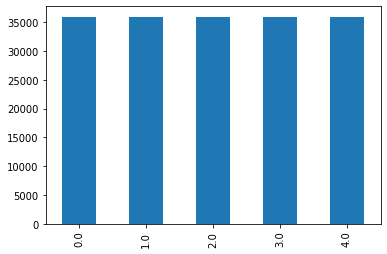

In [ ]:
rus = RandomUnderSampler(random_state=0, replacement=True)
df_resampled, y_resampled = rus.fit_resample(df[['review_full', 'sample']], df.rating_review)
# quick change to labels for BERT indexing
y_resampled = y_resampled - 1
y_resampled.value_counts().plot(kind='bar')

Preprocessing.

In [ ]:
X = df_resampled.review_full.values
y = y_resampled.values

# Split dataset into train, validation, and test sets. 
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.70)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.15)

In [10]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [8]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
# Create a function to tokenize a set of texts for input to BERT model
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in tqdm(data):
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=512,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            truncation=True,
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
def get_dataloader(data, labels, batch_size):

  # convert inputs
  inputs, masks = preprocessing_for_bert(data)
  labels = torch.tensor(labels)
  labels = labels.type(torch.LongTensor)
  
  # arrange in batched dataloader
  dataset = TensorDataset(inputs masks, labels)
  sampler = RandomSampler(dataset)
  dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)

  return dataloader


In [ ]:
# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
train_dataloader = get_dataloader(X_train, y_train, batch_size=32)
val_dataloader = get_dataloader(X_val, y_val, batch_size=32)

In [14]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        
        super(BertClassifier, self).__init__()
        
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
def initialize_model(epochs=4, train_dataloader):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [15]:
# Specify loss function
loss_fn = nn.CrossEntropyLoss()

In [16]:
def train(model, train_dataloader, val_dataloader=None, epochs=4):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        total_loss_tracker = []
        batch_loss_tracker = []
        batch_counts_tracker = []

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss_tracker.append(batch_loss)
                batch_counts_tracker.append(batch_counts)
                total_loss_tracker.append(total_loss)

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

        PATH = 'bert_eng_full_review_' + str(epoch_i) + '.pt'
        torch.save({
            'epoch': epoch_i + 1,
            'model_state_dict': bert_classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'batch_loss_tracker': batch_loss_tracker,
            'total_loss_tracker': total_loss_tracker,
            'batch_counts_tracker': batch_counts_tracker
            }, PATH)
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
# initialize model and begin training!
bert_classifier, optimizer, scheduler = initialize_model(epochs=3, train_dataloader=train_dataloader)
train(bert_classifier, train_dataloader, test_dataloader, epochs=3, evaluation=True)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.441595   |     -      |     -     |   18.01  
   1    |   40    |   1.115404   |     -      |     -     |   14.11  
   1    |   60    |   0.955047   |     -      |     -     |   14.09  
   1    |   80    |   0.952662   |     -      |     -     |   14.09  
   1    |   100   |   0.913323   |     -      |     -     |   14.10  
   1    |   120   |   0.901958   |     -      |     -     |   14.09  
   1    |   140   |   0.875026   |     -      |     -     |   14.12  
   1    |   160   |   0.878141   |     -      |     -     |   14.08  
   1    |   180   |   0.902293   |     -      |     -     |   14.09  
   1    |   200   |   0.816749   |     -      |     -     |   14.07  
   1    |   220   |   0.849118   |     -      |     -     |   14.09  
   1    |   240   |   0.870787   |     -      |     -     |   14.10  


In [ ]:
!cp bert_eng_full_review_2.pt /content/drive/MyDrive/

In [6]:
test_X = pd.read_csv('/content/drive/MyDrive/CWT Data/X_test.csv')
test_y = pd.read_csv('/content/drive/MyDrive/CWT Data/y_test.csv')

In [43]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    test_accuracy = []
    test_loss = []
    test_roc = []
    test_f1 = []

    # For each batch in our validation set...
    for step, batch in enumerate(val_dataloader):

        from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
        # Load batch to GPU

        b_input_ids, b_attn_mask, b_labels = tuple(t.to('cpu') for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        probabilities = nn.functional.softmax(logits, dim=-1).detach().numpy()

        # Calculate metrics
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

        roc = roc_auc_score(b_labels, probabilities, average='macro', multi_class='ovr')
        test_roc.append(roc)

        f1_score = f1_score(b_labels, preds.detach().numpy(), average='macro')
        test_f1.append(f1_score)

        if (step % 20 == 0):
          print(step, np.mean(test_roc))

    # Compute the average accuracy and loss over the validation set.
    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(val_accuracy)
    test_roc = np.mean(test_roc)
    test_f1 = np.mean(test_f1)

    return test_loss, test_accuracy, test_roc, test_f1

In [36]:
def load_model():
  model = BertClassifier(freeze_bert=True)
  model.load_state_dict(torch.load('/content/drive/MyDrive/bert_eng_full_review_2.pt', map_location=torch.device('cuda'))['model_state_dict'])
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  return tokenizer, model

In [37]:
tokenizer, model = load_model()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
test_inputs, test_masks = preprocessing_for_bert(test_X.review_full.values)
test_labels = torch.tensor(test_y.rating_review.values)
test_labels = test_labels.type(torch.LongTensor)
test_labels = test_labels - 1

100%|██████████| 8085/8085 [00:20<00:00, 388.82it/s]


In [39]:
# Create the DataLoader for our validation set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [44]:
test_loss, val_accuracy, test_roc, test_f1 = evaluate(model, test_dataloader)

0 0.9202858807858808
20 0.957084314007995
40 0.9588121788485127
60 0.9557686449505121
80 0.9550429060169028
100 0.9558766573488405
120 0.9569609338953969
140 0.9573204085170887
160 0.9577880719324405
180 0.9580751227981668
200 0.9573806948355792


ValueError: ignored